In [1]:
%config Completer.use_jedi=False

%load_ext autoreload
%autoreload 2

import os
os.sys.path.insert(0, '/home/schirrmr/code/invertible-public/')
os.sys.path.insert(0, '/home/schirrmr/code/invertible-eeg//')
os.sys.path.insert(0, '/home/schirrmr/code/invertible-neurips///')
os.sys.path.insert(0, '/home/schirrmr/code/utils/')
os.sys.path.insert(0, '/home/schirrmr/code/lossy/')
os.sys.path.insert(0, '/home/schirrmr/code/dataset-condensation//')
os.sys.path.insert(0, '/home/schirrmr/code/nfnets/')
os.sys.path.insert(0, '/home/schirrmr/code/cifar10-clf/')
from torch import nn
from invertibleeeg.images.datautil import restrict_to_classes
import torch as th
th.backends.cudnn.benchmark = True
import numpy as np
from tqdm.autonotebook import tqdm, trange
from rtsutils.nb_util import Results
from skorch.utils import to_tensor, to_numpy
from braindecode.util import set_random_seeds
from rtsutils.plot import create_rgb_image, rescale
import PIL.ImageDraw as ImageDraw
from PIL import ImageFont
import higher
import kornia
from itertools import islice
import functools
from functools import partial
from torchvision import transforms
import torchvision

from invertible.view_as import Flatten2d
from invertible.pure_model import NoLogDet
from rtsutils.optim import grads_all_finite 
import pandas as pd
from rtsutils.scheduler import CosineAnnealing
from invertibleeeg.images.optim import RAdam
from torch.optim import Adam

from rtsutils.scheduler import ScheduledOptimizer
import higher
import kornia
from itertools import islice
from invertible.expression import Expression
import functools
from functools import partial
# train one step with optimized inputs 
from rtsutils.plot import create_bw_image, rescale, stack_images_in_rows, create_rgb_image
from torch.optim import Adam
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn
seaborn.set_palette('colorblind')
seaborn.set_style('darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'png'
#matplotlib.rcParams['figure.figsize'] = (12.0, 1.0)
matplotlib.rcParams['font.size'] = 14
from rtsutils.util import th_to_np, np_to_th
import torch
from GPUtil import showUtilization as gpu_usage

import os.path
import sys
from itertools import islice

import kornia
import numpy as np
import torch
import torch as th
from braindecode.models.modules import Expression
from braindecode.util import set_random_seeds
from tensorboardX.writer import SummaryWriter
from torch import nn
from torchvision.utils import save_image

from rtsutils.util import np_to_th, th_to_np
import logging
import sys


import os
os.environ['pytorch_data'] = '/home/schirrmr/data/pytorch-datasets/'
os.environ['mimic_cxr'] = "/work/dlclarge2/schirrmr-mimic-cxr-jpg/physionet.org/files/mimic-cxr-jpg/2.0.0/"
os.environ['small_glow_path'] = "/home/schirrmr/data/exps/invertible-neurips/smaller-glow/21/10_model.th"
os.environ['normal_glow_path'] = "/home/schirrmr/data/exps/invertible/pretrain/57/10_model.neurips.th"



from hyperoptim.results import (load_data_frame, remove_columns_with_same_value,
                                mean_identical_exps, dataset_averaged_frame,
                                extract_epoch_dfs)
import itertools
logging.basicConfig(
    format="%(asctime)s %(levelname)s : %(message)s",
    level=logging.DEBUG,
)
log = logging.getLogger()
log.setLevel("DEBUG")
notebookdir_path = os.path.dirname(os.path.realpath("__file__")).replace('/home/schirrmr/', "")
output_dir = os.path.join('/home/schirrmr/data/exps/notebooks', notebookdir_path)
os.makedirs(output_dir, exist_ok=True)

/home/schirrmr/anaconda3/envs/invertible/lib/python3.7/site-packages/matplotlib_inline/config.py:75: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [2]:
folder = '/work/dlclarge2/schirrmr-eeg-age-competition/exps/'
df = load_data_frame(folder)
df = df[df.finished == 1]
df = df.fillna('-')
df = df[df.debug == 0]
df = df.drop('save_folder', axis=1)
df = df.drop('seed', axis=1)
df.loc[:,'runtime'] = pd.to_timedelta(np.round(df.runtime), unit='s')
print(len(df))
df = df[df.n_swa_epochs != 5]
df = df.drop('n_swa_epochs', axis=1)
df.loc[:460,'valid_loss_orig'] = df.loc[:, 'valid_loss_orig']  * 0.7714086201309
df.loc[:40,'train_loss_orig'] = df.loc[:, 'train_loss_orig']  * 0.7714086201309
#437 before the 960

2022-11-24 11:54:42,269 INFO : Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-11-24 11:54:42,270 INFO : NumExpr defaulting to 8 threads.


1502


In [3]:
df_with_seeds = df[(df.n_epochs >= 30) & (df.train_on_valid != True)
                                 &(df.valid_loss_trial_orig != '-')]

meaned_df = mean_identical_exps(df_with_seeds.drop('np_th_seed', axis=1),
                    result_cols=('runtime', 'valid_loss_orig', 'valid_loss', 'train_loss_orig',
       'finished', 'valid_loss_trial_orig', 'train_loss', 'valid_loss_trial')).sort_values(by='valid_loss_trial_orig')
remove_columns_with_same_value(meaned_df)

,low_cut_hz,lr_schedule,common_average_rereference,n_start_filters,lr,n_swavg_epochs,n_epochs,save_valid_preds,n_exp,runtime,valid_loss_orig,valid_loss,train_loss_orig,valid_loss_trial_orig,train_loss,valid_loss_trial
4,0.5,-,True,50.0,0.0003,10.0,30,True,10,0 days 00:22:27.100000,1.755626,0.103926,0.912281,1.570823,0.054003,0.092986
7,1,-,-,50.0,0.0003,10.0,30,-,10,0 days 00:23:42.300000,1.756746,0.103992,0.920096,1.613470,0.054466,0.095511
2,0.2,-,-,50.0,0.0003,10.0,30,-,10,0 days 00:22:52.100000,1.791861,0.106071,0.826738,1.618578,0.048939,0.095813
3,0.3,-,-,50.0,0.0003,10.0,30,-,10,0 days 00:22:19.800000,1.787702,0.105824,0.868394,1.622735,0.051405,0.096059
1,0.15,-,-,50.0,0.0003,10.0,30,-,10,0 days 00:23:53.600000,1.800880,0.106604,0.836049,1.626728,0.049491,0.096295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,4,-,False,50.0,0.0003,10.0,30,-,10,0 days 00:23:54.100000,3.185158,0.188548,2.672370,3.092252,0.158193,0.183048
13,8,-,True,50.0,0.0003,10.0,30,-,10,0 days 00:22:08.300000,3.212714,0.190179,2.705188,3.145642,0.160136,0.186209
8,2,-,False,50.0,0.0003,10.0,30,-,10,0 days 00:22:26.700000,3.245927,0.192145,2.687409,3.152976,0.159083,0.186643
11,4,-,True,50.0,0.0003,10.0,30,-,10,0 days 00:22:52.800000,3.499326,0.207145,3.042289,3.375097,0.180091,0.199791


In [4]:
remove_columns_with_same_value(
    meaned_df[(meaned_df.n_start_filters == 50) &
             (meaned_df.n_epochs == 30) & (meaned_df.n_swavg_epochs ==10) &
             (meaned_df.lr == 3e-4)  &
             (meaned_df.low_cut_hz == 0.5) &
             (meaned_df.lr_schedule == '-')&
             (meaned_df.common_average_rereference == True)])

""
4


In [5]:
# First check how valid predictions would perform in ensemble

In [6]:
part_valid_df = df[(df.n_start_filters == 50) &
             (df.n_epochs == 30) & (df.n_swavg_epochs ==10) &
             (df.lr == 3e-4)  &
             (df.low_cut_hz == 0.5) &
             (df.lr_schedule == '-')&
             (df.common_average_rereference == True) &
              (df.train_on_valid == False)]

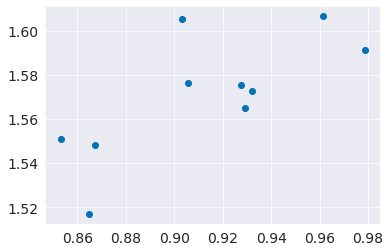

In [8]:
plt.scatter(part_valid_df.train_loss_orig, part_valid_df.valid_loss_trial_orig)

In [9]:
remove_columns_with_same_value(part_valid_df)

,np_th_seed,valid_loss,valid_loss_trial,train_loss_orig,valid_loss_trial_orig,valid_loss_orig,train_loss,runtime
1760,0,0.105525,0.0950339,0.903335,1.60542,1.782654,0.053474,0 days 00:24:12
1762,4,0.104634,0.095096,0.961287,1.60647,1.767598,0.056904,0 days 00:21:32
1764,6,0.101730,0.0897965,0.864627,1.51694,1.718528,0.051182,0 days 00:22:10
1767,5,0.103299,0.0918003,0.853056,1.55079,1.745050,0.050497,0 days 00:21:30
1768,1,0.103928,0.0930997,0.932211,1.57274,1.755659,0.055183,0 days 00:21:49
1770,2,0.105589,0.0941964,0.978673,1.59127,1.783732,0.057933,0 days 00:26:28
1771,3,0.102930,0.0926292,0.929177,1.56479,1.738811,0.055003,0 days 00:21:35
1776,8,0.103643,0.091652,0.867424,1.54829,1.750859,0.051348,0 days 00:21:35
1777,9,0.104016,0.0933029,0.905544,1.57618,1.757151,0.053604,0 days 00:21:43
1779,7,0.103961,0.0932534,0.927477,1.57534,1.756221,0.054903,0 days 00:21:57


In [10]:
part_valid_df.valid_loss_trial_orig.mean()

1.570823009390076

In [11]:
valid_age_preds = []
for i_exp in part_valid_df.sort_values(by='train_loss_orig').index:
    valid_age_preds.append(np.load(
        os.path.join(folder, str(i_exp), 'valid_mean_pred.npy')))

### Load valid trial ys for comparison

In [12]:
%%time
import pickle
data_path = '/work/dlclarge2/schirrmr-eeg-age-competition/pkl-datasets/'
tuabn_valid = pickle.load(open(os.path.join(data_path, 'tuabn_valid.pkl'), 'rb'))

ch_names = tuabn_valid.datasets[0].windows.ch_names
# needed later for inverting target transform
target_scaler = tuabn_valid.target_transform


valid_loader = th.utils.data.DataLoader(
    tuabn_valid,
    batch_size=128,
    shuffle=False,
    num_workers=2)



/home/schirrmr/anaconda3/envs/invertible/lib/python3.7/site-packages/moabb/datasets/neiry.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ("id", np.int),
/home/schirrmr/anaconda3/envs/invertible/lib/python3.7/site-packages/moabb/datasets/neiry.py:79: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review 

CPU times: user 2.24 s, sys: 2.04 s, total: 4.28 s
Wall time: 4.37 s


In [13]:
all_y = []
all_is = []
for X,y,i  in tqdm(valid_loader):
    all_y.append(y.detach().cpu().numpy())
    all_is.append(i)


  0%|          | 0/15 [00:00<?, ?it/s]

In [14]:
i_window_in_trials = np.concatenate(
    [i[0].cpu().numpy() for i in all_is])
window_0_per_trial_mask = np.diff(i_window_in_trials, prepend=[np.inf]) != 1
trial_ys = np.concatenate(all_y)[window_0_per_trial_mask]
subject_ys = trial_ys[tuabn_valid.description.condition == 'EC']

In [15]:
target_scaler = tuabn_valid.target_transform
np.abs(valid_age_preds[0] - subject_ys).mean() * (target_scaler.mult_element -target_scaler.add_element)

1.5507921124283863

In [16]:
remove_columns_with_same_value(part_valid_df.sort_values(by='train_loss_orig'))

,np_th_seed,valid_loss,valid_loss_trial,train_loss_orig,valid_loss_trial_orig,valid_loss_orig,train_loss,runtime
1767,5,0.103299,0.0918003,0.853056,1.55079,1.745050,0.050497,0 days 00:21:30
1764,6,0.101730,0.0897965,0.864627,1.51694,1.718528,0.051182,0 days 00:22:10
1776,8,0.103643,0.091652,0.867424,1.54829,1.750859,0.051348,0 days 00:21:35
1760,0,0.105525,0.0950339,0.903335,1.60542,1.782654,0.053474,0 days 00:24:12
1777,9,0.104016,0.0933029,0.905544,1.57618,1.757151,0.053604,0 days 00:21:43
1779,7,0.103961,0.0932534,0.927477,1.57534,1.756221,0.054903,0 days 00:21:57
1771,3,0.102930,0.0926292,0.929177,1.56479,1.738811,0.055003,0 days 00:21:35
1768,1,0.103928,0.0930997,0.932211,1.57274,1.755659,0.055183,0 days 00:21:49
1762,4,0.104634,0.095096,0.961287,1.60647,1.767598,0.056904,0 days 00:21:32
1770,2,0.105589,0.0941964,0.978673,1.59127,1.783732,0.057933,0 days 00:26:28


In [40]:
np.mean(valid_age_preds[:4], axis=0).max() * (target_scaler.mult_element -target_scaler.add_element)

13.466793201461675

In [31]:
np.mean(valid_age_preds[:1], axis=0).max()* (target_scaler.mult_element -target_scaler.add_element)

13.535786521252039

In [32]:
np.mean(valid_age_preds[:3], axis=0).min() * (target_scaler.mult_element -target_scaler.add_element)

1.0456886247203985

In [33]:
np.mean(valid_age_preds[:1], axis=0).min()* (target_scaler.mult_element -target_scaler.add_element)

0.9866670271468536

In [42]:
np.abs(np.mean(valid_age_preds[:3], axis=0) - subject_ys).mean() * (target_scaler.mult_element -target_scaler.add_element)

1.519403344557536

In [89]:
# load all valid pred arrs
# also load valid set to get ys and is
# then you can mean or compare etc by mask based on losses

In [71]:
part_df_test = df[(df.n_start_filters == 50) &
             (df.n_epochs == 30) & (df.n_swavg_epochs ==10) &
             (df.lr == 3e-4)  &
             (df.low_cut_hz == 0.5) &
             (df.lr_schedule == '-')&
             (df.common_average_rereference == True) &
                (df.train_on_valid == True)]

In [72]:
remove_columns_with_same_value(part_df_test.sort_values(by='train_loss_orig'))

,np_th_seed,valid_loss,valid_loss_trial,train_loss_orig,valid_loss_trial_orig,valid_loss_orig,train_loss,runtime
1763,4,0.049935,0.0427522,0.822208,0.722218,0.843554,0.048671,0 days 00:25:54
1769,2,0.051927,0.0434199,0.854608,0.733497,0.877209,0.050589,0 days 00:27:30
1775,8,0.052588,0.0447884,0.878158,0.756615,0.888372,0.051983,0 days 00:26:05
1766,5,0.053755,0.0456561,0.882239,0.771273,0.908082,0.052225,0 days 00:25:43
1765,6,0.053942,0.0462072,0.885987,0.780584,0.911246,0.052447,0 days 00:27:00
1773,1,0.054927,0.046808,0.909385,0.790732,0.927881,0.053832,0 days 00:28:20
1780,9,0.056410,0.0485205,0.922515,0.819662,0.952938,0.054609,0 days 00:45:55
1772,0,0.058398,0.0498629,0.968870,0.842339,0.986528,0.057353,0 days 00:26:00
1778,7,0.064045,0.0549316,1.026710,0.927966,1.081911,0.060777,0 days 00:25:58
1761,3,0.072315,0.0690185,1.200309,1.16594,1.221630,0.071053,0 days 00:25:49


In [73]:
submission_dfs = []
for exp_id in part_df_test.sort_values(by='train_loss_orig').index[:3]:
    submission_dfs.append(pd.read_csv(os.path.join(folder, str(exp_id), 'submission.csv')))

age_preds = [np.array(d.age) for d in submission_dfs]
mean_age_pred = np.mean(np.stack(age_preds, axis=0), axis=0)

tuabn_eval_df = pd.DataFrame({'id': submission_dfs[0].id, 'age': mean_age_pred})
tuabn_eval_df.to_csv(os.path.join('./final_submission.csv'), index=False)

In [74]:
final_submission_df = pd.read_csv('final_submission.csv')

In [75]:
final_submission_df.age.min()

6.212793333333334

In [76]:
final_submission_df.age.max()

17.39847333333333

In [77]:
submission_dfs[0].age.min()

5.942302

In [78]:
submission_dfs[0].age.max()

17.834967000000002

In [79]:
mean_age_pred.min()

6.212793333333334

In [80]:
mean_age_pred.max()

17.39847333333333

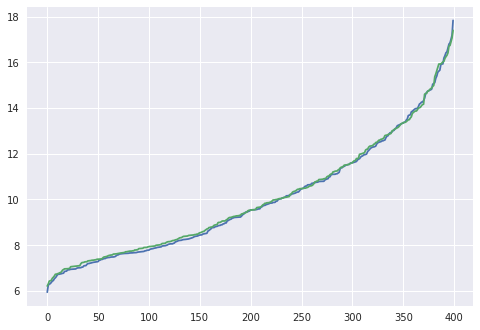

In [81]:
plt.plot(sorted(submission_dfs[0].age))
plt.plot(sorted(mean_age_pred))

In [82]:
mv final_submission.csv /home/schirrmr/code/

In [83]:
ls -ahl /home/schirrmr/code/final_submission.csv

-rw-r--r-- 1 schirrmr nail 8.5K Nov 24 12:01 /home/schirrmr/code/final_submission.csv
